<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Image Explainability using XWhy</b></div>

<a id="1.2"></a>
<h2 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #155D07; background-color: #ffffff;"><b>Comparing</b> Image Exlainability of XWhy with LIME and BayLIME</h2>

<p style="text-align: justify;">With the ever-increasing complexity of machine learning models, explainability has become an indispensable element of effective data analysis. Sophisticated algorithms like deep learning can offer tremendous predictive power, but their "black box" nature can obscure understanding and limit their practical application. Hence, the demand for tools and techniques that elucidate the decision-making processes of these models has grown significantly. Among the tools that have emerged to tackle this issue, model-agnostic approaches like Local Interpretable Model-Agnostic Explanations (LIME) and Bayesian Local Interpretable Model-Agnostic Explanations (BayLIME) have made substantial contributions. They provide localized explanations of predictions, offering insights into how and why a specific prediction was made, thus boosting the transparency and interpretability of complex models.</p>

<p style="text-align: justify;">However, as the field of explainability continues to evolve, the quest for superior methods remains unquenched. Our paper introduces a novel approach, X-Why, designed to enhance the explainability of machine learning models beyond the capabilities of existing methods utilizing statistical distance measures like Wasserstein. X-Why aims to improve the interpretability gap left by traditional methods like LIME and BayLIME, taking the science of model explainability a step further. The intent is to provide more comprehensive, intuitive, and robust interpretations of predictions, thus enabling more informed decision-making in software systems. This study aims to present a comparative analysis of X-Why with existing model-agnostic approaches to demonstrate its potential benefits and improvements over other techniques in the field of explainable artificial intelligence.</p>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
* [Import Libraries](#lib)
* [Step-by-Step Implementation of LIME](#step_LIME) 
* [Defining LIME Function](#LIME)
* [Defining XWhy Function with Wasserstein Distance](#xwhy_wd)
* [Comparing XWhy with LIME](#comp_LIME)
* [Comparing XWhy with BayLIME](#comp_BayLIME)
* [Defining XWhy Function with Anderson Darling Distance](#xwhy_add)
* [Defining XWhy Function with Kolmogorov Smirnov Distance](#xwhy_ksd)
* [Comparing XWhy with SHAP (Under Construction :D)](#comp_SHAP)
* [References](#ref)

<a id="2"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Import libraries</b></div>

In [1]:
#%tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

import matplotlib.pyplot as plt

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.4.3


<a id="step_LIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Step-by-step Implementation of LIME</b></div>

The first step is to import a model that we would like I) to use for image classification and II) to test for explainabiity.

In [2]:
warnings.filterwarnings('ignore') 
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model
#inceptionV3_model.summary()

96116736/96112376 [==============================] - 1s 0us/step


The second step is to import the image and resize it for to be used as an input for the model.

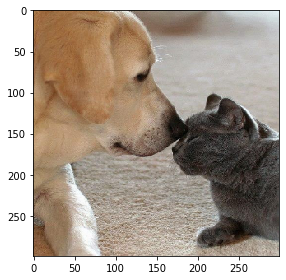

In [3]:
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [4]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

40960/35363 [==================================] - 0s 0us/step


[('n02099712', 'Labrador_retriever', 0.8273345),
 ('n02099601', 'golden_retriever', 0.014789678),
 ('n02093428', 'American_Staffordshire_terrier', 0.008711376),
 ('n02108422', 'bull_mastiff', 0.008177877),
 ('n02109047', 'Great_Dane', 0.007899403)]

In [5]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes                #Index of top 5 classes

array([208, 207, 180, 243, 246])

In [6]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

68

In [7]:
Xi.shape

(299, 299, 3)

In [8]:
np.unique(superpixels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

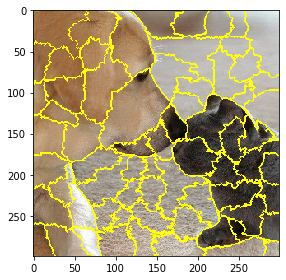

In [9]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [10]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1])

In [11]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

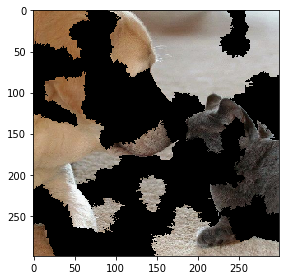

In [12]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [13]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

In [14]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [15]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [16]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01998327, -0.01601365,  0.10354323, -0.04821656,  0.08925857,
        0.07826846,  0.02714033,  0.07659383,  0.1812233 , -0.05638586,
        0.03509665,  0.0047035 ,  0.02208912,  0.10356663,  0.07223711,
        0.00347347,  0.08162891,  0.03907238,  0.00769063,  0.02527217,
       -0.01004945,  0.02130285, -0.07029255, -0.02555166,  0.52121148,
        0.02055336,  0.00131826, -0.17025002, -0.03082541,  0.14881239,
        0.05691074,  0.10112572, -0.01224571, -0.04081402, -0.038643  ,
       -0.02153381, -0.0574592 ,  0.02746985,  0.03796644,  0.03152446,
        0.03358091,  0.00733324,  0.04806789, -0.02303119, -0.01457855,
        0.08431812,  0.00803597, -0.01945872, -0.09000525,  0.05641908,
        0.0287426 ,  0.01926108, -0.03653444,  0.03901719, -0.05825472,
        0.03474141, -0.10268785,  0.00780921, -0.03470864,  0.03349203,
        0.06900828, -0.0514199 ,  0.0221941 ,  0.05436443,  0.01072265,
       -0.03208547,  0.09252433, -0.00573772])

In [17]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([13, 29,  8, 24])

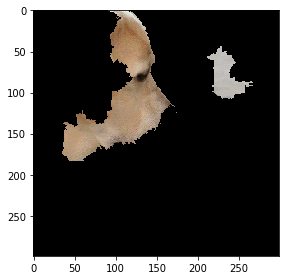

In [18]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

<a id="LIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining LIME Function</b></div>
Here the LIME function is defined as "xwhy_image".

In [19]:
def xwhy_image(X_input, model, num_perturb = 150, kernel_width = 0.25):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=4, max_dist=200, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff, perturbations

68
CPU times: user 52.5 s, sys: 997 ms, total: 53.5 s
Wall time: 20.6 s


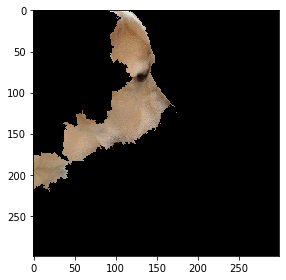

In [20]:
%%time
coeff, perturbations = xwhy_image(Xi, model=inceptionV3_model)

print(len(coeff))

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

<a id="xwhy_wd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining XWhy Function with Wasserstein Distance</b></div>

In [21]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def  Wasserstein_Dist_PVal(XX, YY):
    # Information about Bootstrap: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    WD = Wasserstein_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_WD = Wasserstein_Dist(comb[e],comb[f]);
        if (boost_WD > WD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, WD

def Wasserstein_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        WD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            WD.append(Wasserstein_Dist(im1, im2))
            
    return sum(WD)
  
def xwhy_image_wd(X_input, model, num_perturb = 400, kernel_width = 0.25):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=3, max_dist=200, ratio=0.25)
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    WD_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)
        WD_dist = Wasserstein_Dist_Image(X_input, perturbed_img)
        

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    # distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(WD_dist**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff

CPU times: user 3min 37s, sys: 1.04 s, total: 3min 38s
Wall time: 2min 58s


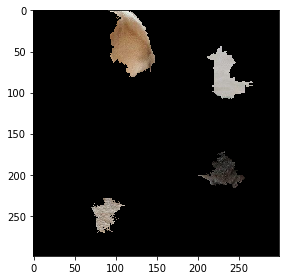

In [22]:
%%time
coeff = xwhy_image_wd(Xi, model=inceptionV3_model, num_perturb = 200, kernel_width = 0.25)

num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

<a id="comp_LIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with LIME</b></div>

In [23]:
# Xi_L = skimage.io.imread("../input/lime-img-ex/LIME_Img_ex.JPG")
# Xi_L = skimage.transform.resize(Xi_L, (299,299)) 
# Xi_L = (Xi_L - 0.5)*2 #Inception pre-processing
# skimage.io.imshow(Xi_L/2+0.5) # Show image before inception preprocessing

In [24]:
# preds_L = inceptionV3_model.predict(Xi_L[np.newaxis,:,:,:])
# decode_predictions(preds_L)[0] #Top 5 classes

In [25]:
# top_pred_classes_L = preds_L[0].argsort()[-5:][::-1]
# top_pred_classes_L               #Index of top 5 classes

In [26]:
# superpixels_L = skimage.segmentation.quickshift(Xi_L, kernel_size=7,max_dist=100, ratio=0.2)
# num_superpixels_L = np.unique(superpixels_L).shape[0]

# print(num_superpixels_L)

# skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi_b/2+0.5, superpixels_L))

In [27]:
# %%time
# coeff, perturbations = xwhy_image(Xi_L, model=inceptionV3_model)

# num_top_features = 4
# top_features = np.argsort(coeff)[-num_top_features:] 
# mask = np.zeros(num_superpixels) 
# mask[top_features]= True #Activate top superpixels
# skimage.io.imshow(perturb_image(Xi_L/2+0.5,mask,superpixels) )

In [28]:
# %%time
# coeff = xwhy_image_wd(Xi_L, model=inceptionV3_model)

# num_top_features = 4
# top_features = np.argsort(coeff)[-num_top_features:] 
# mask = np.zeros(num_superpixels) 
# mask[top_features]= True #Activate top superpixels
# skimage.io.imshow(perturb_image(Xi_L/2+0.5,mask,superpixels) )

<a id="comp_BayLIME"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with BayLIME</b></div>

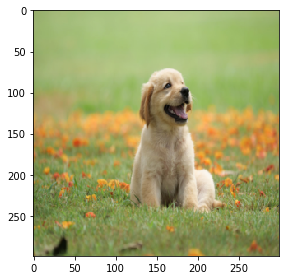

In [29]:
Xi_b = skimage.io.imread("/kaggle/input/baylimeimgex5/5.jpg")
Xi_b = skimage.transform.resize(Xi_b, (299,299)) 
Xi_b = (Xi_b - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi_b/2+0.5) # Show image before inception preprocessing

In [30]:
preds_b = inceptionV3_model.predict(Xi_b[np.newaxis,:,:,:])
decode_predictions(preds_b)[0] #Top 5 classes

[('n02099601', 'golden_retriever', 0.8392913),
 ('n02099712', 'Labrador_retriever', 0.06735157),
 ('n02101556', 'clumber', 0.019285545),
 ('n02102318', 'cocker_spaniel', 0.0039173863),
 ('n02101388', 'Brittany_spaniel', 0.0018120747)]

In [31]:
top_pred_classes_b = preds_b[0].argsort()[-5:][::-1]
top_pred_classes_b               #Index of top 5 classes

array([207, 208, 216, 219, 215])

24


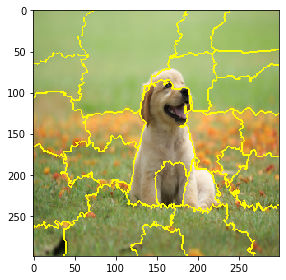

In [32]:
superpixels_b = skimage.segmentation.quickshift(Xi_b, kernel_size=7,max_dist=100, ratio=0.2)
num_superpixels_b = np.unique(superpixels_b).shape[0]

print(num_superpixels_b)

skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi_b/2+0.5, superpixels_b))

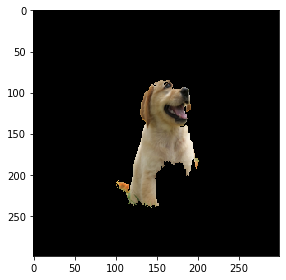

In [33]:
# superpixels = skimage.segmentation.quickshift(X_input, kernel_size=3, max_dist=200, ratio=0.25)
# num_superpixels = np.unique(superpixels).shape[0]
perturbations_b = np.random.binomial(1, 0.5, size=(200, num_superpixels_b))


def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
          mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

predictions = []
WD_dist = []
for pert in perturbations_b:
    perturbed_img = perturb_image(Xi_b,pert,superpixels_b)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)
    WD_dist = Wasserstein_Dist_Image(Xi_b, perturbed_img)

predictions = np.array(predictions)

original_image = np.ones(num_superpixels_b)[np.newaxis,:] #Perturbation with all superpixels enabled 
# distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()

weights = np.sqrt(np.exp(-(WD_dist**2)/kernel_width**2)) #Kernel function

class_to_explain = top_pred_classes_b[0]
simpler_model_b = LinearRegression()
simpler_model_b.fit(X=perturbations_b, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff_b = simpler_model_b.coef_[0]

num_top_features = 1
top_features = np.argsort(coeff_b)[-num_top_features:] 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_b) )

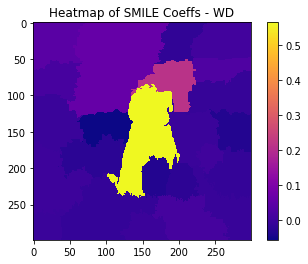

In [34]:
def create_heat_mask(superpixels_b, coeff):
    # Initialize an empty image
    heat_mask = np.zeros_like(superpixels_b, dtype=float)

    # Iterate over the unique labels of the superpixels
    for idx, label in enumerate(np.unique(superpixels_b)):
        # Set the pixels of the current superpixel to its corresponding coefficient
        heat_mask[superpixels_b == label] = coeff[idx]
    
    return heat_mask

heat_mask_wd = create_heat_mask(superpixels_b, coeff_b)

plt.imshow(heat_mask_wd, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - WD')
plt.show()

<a id="xwhy_add"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining XWhy Function with Anderson Darling Distance</b></div>

In [35]:
def Anderson_Darling_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    G_CDF = 0
    height = 0
    SD = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        G_CDF = G_CDF + 1/n
        SD = (n * G_CDF * (1-G_CDF))**0.5
        height = abs(F_CDF - E_CDF)
        if XY_Sorted[ii+1] != XY_Sorted[ii]: 
            if SD>0: 
                Res = Res + (height/SD)**power

    AD_Dist = Res
    
    return AD_Dist

def  Anderson_Darling_Dist_PVal(XX, YY):
    # Information about Bootstrap Method: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    AD = Anderson_Darling_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_AD = Anderson_Darling_Dist(comb[e],comb[f]);
        if (boost_AD > AD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, AD

def Anderson_Darling_Dist_Image(img1, img2):
    flag = 0
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        ADD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())
            
            AD = Anderson_Darling_Dist(im1, im2)
            
            if AD == 0:
                flag = 1
            else:
                ADD.append(AD)
            
    return sum(ADD)

def xwhy_image_ad(X_input, model, perturbations=perturbations_b, num_perturb = 150, kernel_width = 0.9, top_pred_classes= top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=7,max_dist=100, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    #perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    AD_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)
        AD_dist = Anderson_Darling_Dist_Image(X_input, perturbed_img)+0.01
        

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    # distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    epsilon = 1e-6  # A small constant
    weights = np.sqrt(np.exp(-(AD_dist**2)/kernel_width**2)) + epsilon
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff_ad = simpler_model.coef_[0]
        
    return coeff_ad

CPU times: user 3min 24s, sys: 1.05 s, total: 3min 25s
Wall time: 2min 46s


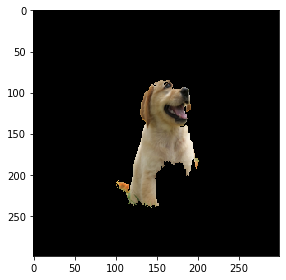

In [36]:
%%time
coeff_ad = xwhy_image_ad(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_ad)[-num_top_features:] 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_b) )

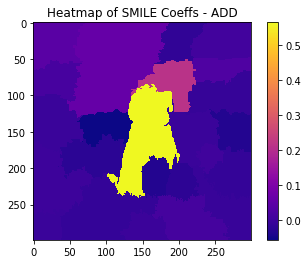

In [37]:
heat_mask_ad = create_heat_mask(superpixels_b, coeff_ad)

plt.imshow(heat_mask_ad, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - ADD')
plt.show()

<a id="xwhy_ksd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining XWhy Function with Kolmogorov Smirnov Distance</b></div>


In [38]:
def Kolmogorov_Smirnov_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0;
    height = 0;
    E_CDF = 0;
    F_CDF = 0;
    power = 1;

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        if XY_Sorted[ii+1] != XY_Sorted[ii]: height = abs(F_CDF-E_CDF)
        if height > Res: Res = height

    KS_Dist = Res**power
    
    return KS_Dist
  
def  Kolmogorov_Smirnov_Dist_PVal(XX, YY):
    # Information about Bootstrap Method: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    KSD = Kolmogorov_Smirnov_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_KSD = Kolmogorov_Smirnov_Dist(comb[e],comb[f]);
        if (boost_KSD > KSD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, KSD

def Kolmogorov_Smirnov_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        KSD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            KSD.append(Kolmogorov_Smirnov_Dist(im1, im2))
            
    return sum(KSD)

def xwhy_image_ks(X_input, model, perturbations=perturbations, num_perturb = 150, kernel_width = 0.25, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=7,max_dist=100, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    KS_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)
        KS_dist = Kolmogorov_Smirnov_Dist_Image(X_input, perturbed_img)
        
    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 

    weights = np.sqrt(np.exp(-(KS_dist**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff_ks = simpler_model.coef_[0]
        
    return coeff_ks

CPU times: user 1min 58s, sys: 810 ms, total: 1min 59s
Wall time: 1min 30s


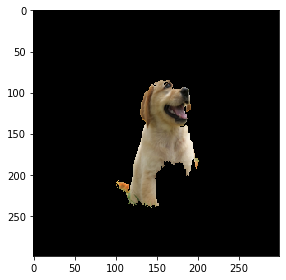

In [39]:
%%time
coeff_ks = xwhy_image_ks(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_ks)[-num_top_features:] 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_b) )

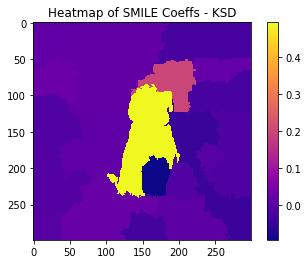

In [40]:
heat_mask_ks = create_heat_mask(superpixels_b, coeff_ks)

plt.imshow(heat_mask_ks, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - KSD')
plt.show()

<a id="xwhy_kd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining XWhy Function with Kuiper Distance</b></div>


In [41]:
def Kuiper_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    up = 0
    down = 0
    Res = 0
    E_CDF = 0
    F_CDF = 0
    height = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        if XY_Sorted[ii+1] != XY_Sorted[ii]: height = F_CDF-E_CDF
        if height > up: up = height
        if height < down: down = height

    K_Dist = abs(down)**power + abs(up)**power
    
    return K_Dist

def  Kuiper_Dist_PVal(XX, YY):
    # Information about Bootstrap Method: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    KD = Kuiper_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_KD = Kuiper_Dist(comb[e],comb[f]);
        if (boost_KD > KD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, KD

def Kuiper_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        KD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            KD.append(Kuiper_Dist(im1, im2))
            
    return sum(KD)

def xwhy_image_k(X_input, model, perturbations=perturbations, num_perturb = 150, kernel_width = 0.25, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=7,max_dist=100, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    K_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)
        K_dist = Kuiper_Dist_Image(X_input, perturbed_img)
        
    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 

    weights = np.sqrt(np.exp(-(K_dist**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff_k = simpler_model.coef_[0]
        
    return coeff_k

CPU times: user 2min 4s, sys: 733 ms, total: 2min 5s
Wall time: 1min 36s


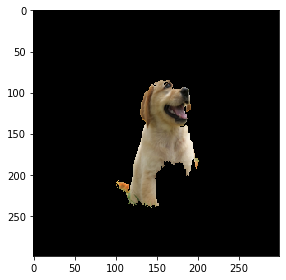

In [42]:
%%time
coeff_k = xwhy_image_k(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_k)[-num_top_features:] 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_b) )

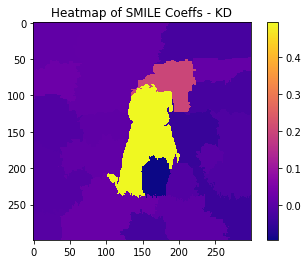

In [43]:
heat_mask_k = create_heat_mask(superpixels_b, coeff_k)

plt.imshow(heat_mask_k, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - KD')
plt.show()

<a id="xwhy_ksd"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Defining XWhy Function with Cramer-Von Mises Distance</b></div>


In [44]:
# Cramer-Von Mises Distance
def CVM_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0;
    E_CDF = 0;
    F_CDF = 0;
    power = 1;

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF - E_CDF)
        if XY_Sorted[ii+1] != XY_Sorted[ii]: Res = Res + height**power

    CVM_Dist = Res
    
    return CVM_Dist

def  CVM_Dist_PVal(XX, YY):
    # Information about Bootstrap Method: 
    # https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60
    import random
    nboots = 1000
    CVMD = CVM_Dist(XX,YY)
    na = len(XX)
    nb = len(YY)
    n = na + nb
    comb = np.concatenate([XX,YY])
    reps = 0
    bigger = 0
    for ii in range(1, nboots):
        e = random.sample(range(n), na)
        f = random.sample(range(n), nb)
        boost_CVM = CVM_Dist(comb[e],comb[f]);
        if (boost_CVM > CVMD):
            bigger = 1 + bigger
            
    pVal = bigger/nboots;

    return pVal, CVMD

def CVM_Dist_Image(img1, img2):
    if img1.shape[0] != img2.shape[0] or img1.shape[1] != img2.shape[1]:
        pritn('input images should have the same size')
    else:
        CVMD = []
        for ii in range(3):
            
            im1 = np.array(img1[:,:,ii].flatten())
            im2 = np.array(img2[:,:,ii].flatten())

            CVMD.append(CVM_Dist(im1, im2))
            
    return sum(CVMD)

def xwhy_image_cvm(X_input, model, perturbations=perturbations, num_perturb = 150, kernel_width = 0.85, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=7,max_dist=100, ratio=0.2)
    num_superpixels = np.unique(superpixels).shape[0]
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    CVM_dist = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)
        CVM_dist = Kuiper_Dist_Image(X_input, perturbed_img)
        
    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 

    epsilon = 1e-6  # A small constant
    weights = np.sqrt(np.exp(-(CVM_dist**2)/kernel_width**2)) + epsilon
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff_CVM = simpler_model.coef_[0]
        
    return coeff_CVM

CPU times: user 2min 4s, sys: 743 ms, total: 2min 5s
Wall time: 1min 36s


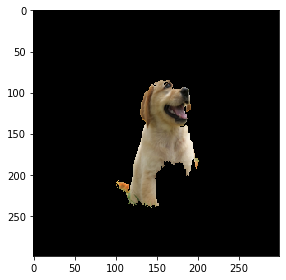

In [45]:
%%time
coeff_cvm = xwhy_image_cvm(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_cvm)[-num_top_features:] 
mask = np.zeros(num_superpixels_b) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_b) )

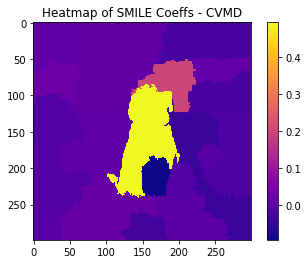

CPU times: user 162 ms, sys: 992 µs, total: 163 ms
Wall time: 162 ms


In [46]:
%%time
heat_mask_cvm = create_heat_mask(superpixels_b, coeff_cvm)

plt.imshow(heat_mask_cvm, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - CVMD')
plt.show()

In [47]:
def xwhy_image(X_input, model, num_perturb = 200, kernel_width = 0.25, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=5, max_dist=200, ratio=0.2)
#     superpixels = skimage.segmentation.slic(X_input, n_segments=150, compactness=10, sigma=1,start_label=1)                 
    
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
    
    class_to_explain = top_pred_classes[0]
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
    coeff = simpler_model.coef_[0]
        
    return coeff, superpixels

CPU times: user 1min 8s, sys: 1.05 s, total: 1min 9s
Wall time: 26.7 s


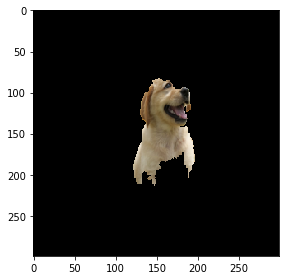

In [48]:
%%time
coeff_lime, superpixels_lime = xwhy_image(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_lime)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels_lime).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_lime) )

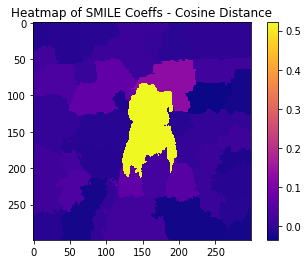

In [49]:
heat_mask_lime = create_heat_mask(superpixels_lime, coeff_lime)

plt.imshow(heat_mask_lime, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - Cosine Distance')
plt.show()

<a id="xwhy_all"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>XWhy All in One</b></div>

(-0.5, 298.5, 298.5, -0.5)

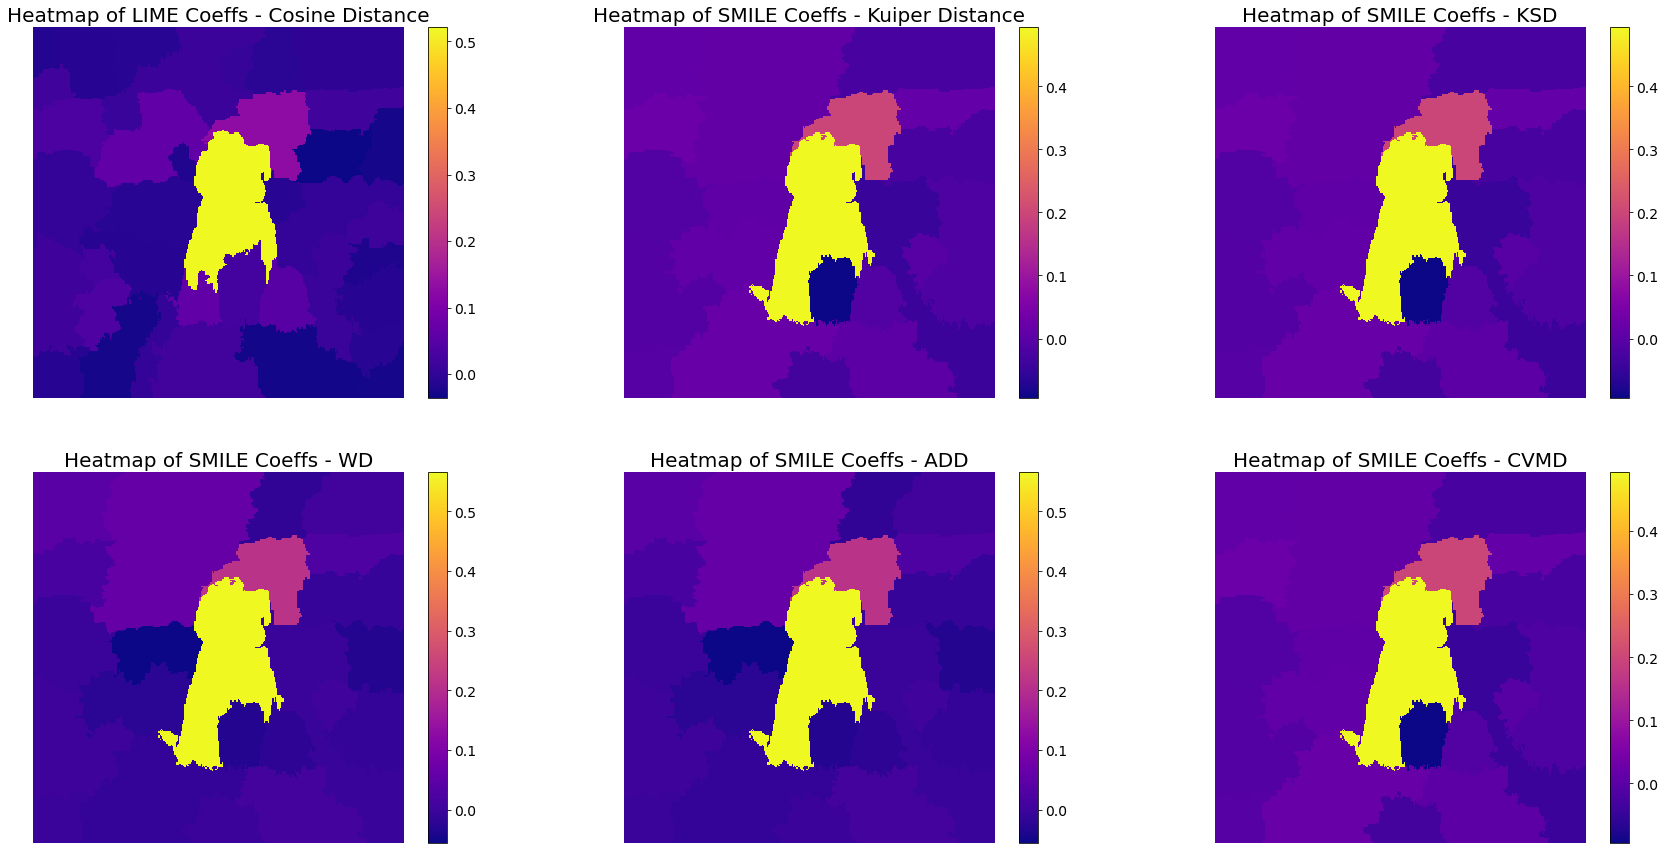

In [50]:
fig, axs = plt.subplots(2, 3, figsize=(30, 15)) 

fz = 20

im = axs[0,0].imshow(heat_mask_lime, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,0])
cbar.ax.tick_params(labelsize=14)  
axs[0,0].set_title('Heatmap of LIME Coeffs - Cosine Distance', fontsize= fz)
axs[0,0].axis('off')

im = axs[0,1].imshow(heat_mask_k, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,1])
cbar.ax.tick_params(labelsize=14)  
axs[0,1].set_title('Heatmap of SMILE Coeffs - Kuiper Distance', fontsize= fz)
axs[0,1].axis('off')

im = axs[0,2].imshow(heat_mask_ks, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,2])
cbar.ax.tick_params(labelsize=14)  
axs[0,2].set_title('Heatmap of SMILE Coeffs - KSD', fontsize= fz)
axs[0,2].axis('off')

im = axs[1,0].imshow(heat_mask_wd, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,0])
cbar.ax.tick_params(labelsize=14)  
axs[1,0].set_title('Heatmap of SMILE Coeffs - WD', fontsize= fz)
axs[1,0].axis('off')

im = axs[1,1].imshow(heat_mask_ad, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,1])
cbar.ax.tick_params(labelsize=14)  
axs[1,1].set_title('Heatmap of SMILE Coeffs - ADD', fontsize= fz)
axs[1,1].axis('off')

im = axs[1,2].imshow(heat_mask_cvm, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,2])
cbar.ax.tick_params(labelsize=14)  
axs[1,2].set_title('Heatmap of SMILE Coeffs - CVMD', fontsize= fz)
axs[1,2].axis('off')

<a id="comp_SHAP"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with Weak Implementation of SHAP</b></div>

19


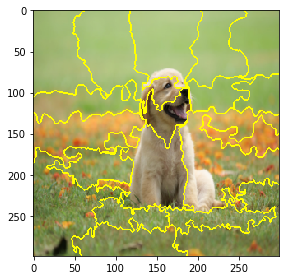

In [51]:
superpixels_b = skimage.segmentation.slic(Xi_b, n_segments=21, compactness=10, sigma=1,start_label=1)     
num_superpixels_b = np.unique(superpixels_b).shape[0]

print(num_superpixels_b)

skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi_b/2+0.5, superpixels_b))

In [52]:
%%time
import sklearn

import scipy.special
import itertools

# SHAP Implementation from 
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.html

def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
              mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image

def predict_proba_feature(X_input, perturbations):
#     perturb_prediction = []
#     for subset in perturbations:
#         data = sample * subset
#         perturb_prediction.append(np.max(model.predict(data)))
    perturb_prediction = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        perturb_prediction.append(pred[0])

    return perturb_prediction

def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 10000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def kernel_shap(f, x, reference, M, X_input):
    X = np.zeros((2**M,M+1))
    X[:,-1] = 1
    weights = np.zeros(2**M)
    V = np.zeros((2**M,M))
    for i in range(2**M):
        V[i,:] = reference

    for i,s in enumerate(powerset(range(M))):
        s = list(s)
        V[i,s] = x[s]
        X[i,s] = 1
        weights[i] = shapley_kernel(M,len(s))
    y = f(X_input, V)
    tmp = np.linalg.inv(np.dot(np.dot(X.T, np.diag(weights)), X))
    return np.dot(tmp, np.dot(np.dot(X.T, np.diag(weights)), y)) # Linear regression with kernel (weights)!


superpixels = skimage.segmentation.slic(Xi_b, n_segments=21, compactness=7, sigma=1,start_label=1)               
num_superpixels = np.unique(superpixels).shape[0]
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

M = num_superpixels
reference = np.zeros(M)
phi = kernel_shap(predict_proba_feature, np.ones(M), reference, M, Xi_b)
shap_values = phi[:-1]



CPU times: user 45min 54s, sys: 44.1 s, total: 46min 38s
Wall time: 17min 12s


In [53]:
import pandas as pd
SHAP_df = pd.DataFrame(shap_values.T)
SHAP_df


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.435959e-09,-0.000048,-0.000039,-0.000111,-3.503573e-05,-0.000028,0.000025,-0.000057,-0.000049,-0.000048,-0.000001,1.318672e-05,-6.224261e-06
1,-3.391895e-09,-0.000161,-0.000034,-0.000390,-2.812237e-05,0.000086,0.000163,-0.000240,0.000195,0.000005,0.000147,1.366490e-05,-9.373886e-08
2,5.172091e-10,-0.000065,-0.000033,-0.000043,1.290774e-06,-0.000008,0.000086,-0.000032,-0.000022,-0.000058,-0.000044,-4.816153e-06,-3.206972e-06
3,9.626278e-10,-0.000086,-0.000031,-0.000079,-2.137689e-05,-0.000010,0.000033,-0.000026,-0.000011,0.000010,-0.000030,9.719202e-07,8.117012e-06
4,-4.505639e-09,-0.000252,0.000112,-0.000207,-4.887211e-05,-0.000025,-0.000194,-0.000201,0.000657,-0.000184,-0.000109,-2.534579e-05,2.627042e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-5.061821e-09,0.000100,0.000008,-0.000647,2.601383e-05,0.000025,0.000017,-0.000107,0.000070,-0.000387,0.000421,2.248237e-04,1.645288e-04
996,-5.570881e-09,-0.000096,0.000062,-0.000325,1.772663e-04,-0.000009,-0.000151,-0.000122,0.000008,-0.000197,0.000152,5.193647e-05,3.149949e-04
997,-6.513799e-10,-0.000060,0.000049,-0.000077,5.807204e-07,-0.000020,0.000042,-0.000070,-0.000035,-0.000056,0.000095,2.639924e-05,1.729268e-05
998,-5.530416e-10,-0.000038,-0.000016,-0.000141,-2.364878e-05,0.000006,-0.000051,-0.000045,0.000020,-0.000081,0.000021,6.335384e-05,6.687373e-05


In [54]:
max_shap_values = np.max(shap_values, axis=1)
max_shap_values

array([5.78090704e-07, 1.85846742e-01, 4.42413905e-02, 4.57667708e-01,
       2.53921265e-02, 2.22592492e-02, 5.73669803e-02, 1.90905810e-01,
       3.79529735e-02, 2.17361984e-01, 1.82451772e-02, 8.21082962e-03,
       1.02549955e-02])

In [55]:
average_shap_values = np.mean(shap_values, axis=1)
average_shap_values

array([-5.72293588e-15, -1.70851946e-11, -1.24406387e-11,  1.80497489e-12,
       -2.66046775e-11, -3.22471262e-11, -1.89346302e-11, -2.49606010e-11,
       -1.08110262e-11, -1.60723683e-11,  8.84646591e-12, -7.42837823e-12,
        1.34947336e-11])

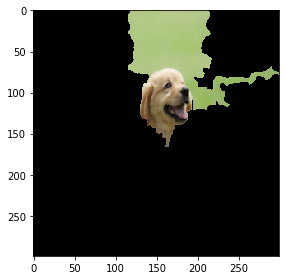

In [56]:
num_top_features = 1
top_features = np.argsort(max_shap_values)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels))

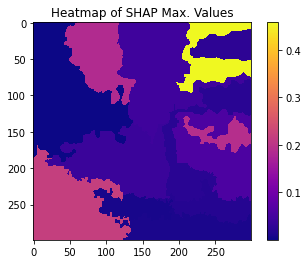

In [57]:
heat_mask_shap = create_heat_mask(superpixels, max_shap_values)

plt.imshow(heat_mask_shap, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SHAP Max. Values')
plt.show()

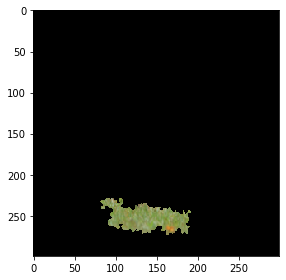

In [58]:
num_top_features = 1
top_features = np.argsort(average_shap_values)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels))

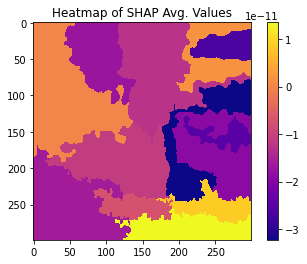

In [59]:
heat_mask_shap2 = create_heat_mask(superpixels, average_shap_values)

plt.imshow(heat_mask_shap2, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SHAP Avg. Values')
plt.show()

<a id="comp_BayLIME_Weak"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with Weak Implementation of BayLIME</b></div>

In [60]:
from sklearn.linear_model import BayesianRidge

def xwhy_BayLIME_image(X_input, model, num_perturb = 200, kernel_width = 0.25, top_pred_classes = top_pred_classes_b):
    
    superpixels = skimage.segmentation.quickshift(X_input, kernel_size=5, max_dist=200, ratio=0.2)
    
    num_superpixels = np.unique(superpixels).shape[0]
    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
    
    def perturb_image(img,perturbation,segments):
        active_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(segments.shape)
        for active in active_pixels:
            mask[segments == active] = 1 
        perturbed_image = copy.deepcopy(img)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        return perturbed_image
    
    predictions = []
    for pert in perturbations:
        perturbed_img = perturb_image(X_input,pert,superpixels)
        pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
        predictions.append(pred)

    predictions = np.array(predictions)
    
    original_image = np.ones(num_superpixels)[np.newaxis,:] 
    distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
    
    weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2))
    
    class_to_explain = top_pred_classes[0]
    simpler_model = BayesianRidge()
    simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain].ravel(), sample_weight=weights)
    coeff = simpler_model.coef_
        
    return coeff, superpixels

CPU times: user 1min 9s, sys: 1.05 s, total: 1min 10s
Wall time: 27 s


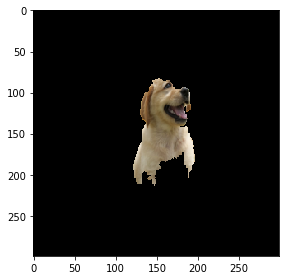

In [61]:
%%time
coeff_BayLIME, superpixels_BayLIME = xwhy_BayLIME_image(Xi_b, model=inceptionV3_model)

num_top_features = 1
top_features = np.argsort(coeff_BayLIME)[-num_top_features:] 
mask = np.zeros(np.unique(superpixels_BayLIME).shape[0]) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi_b/2+0.5,mask,superpixels_BayLIME) )

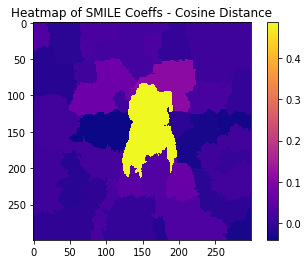

In [62]:
heat_mask_BayLIME = create_heat_mask(superpixels_BayLIME, coeff_BayLIME)

plt.imshow(heat_mask_BayLIME, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of SMILE Coeffs - Cosine Distance')
plt.show()

(-0.5, 298.5, 298.5, -0.5)

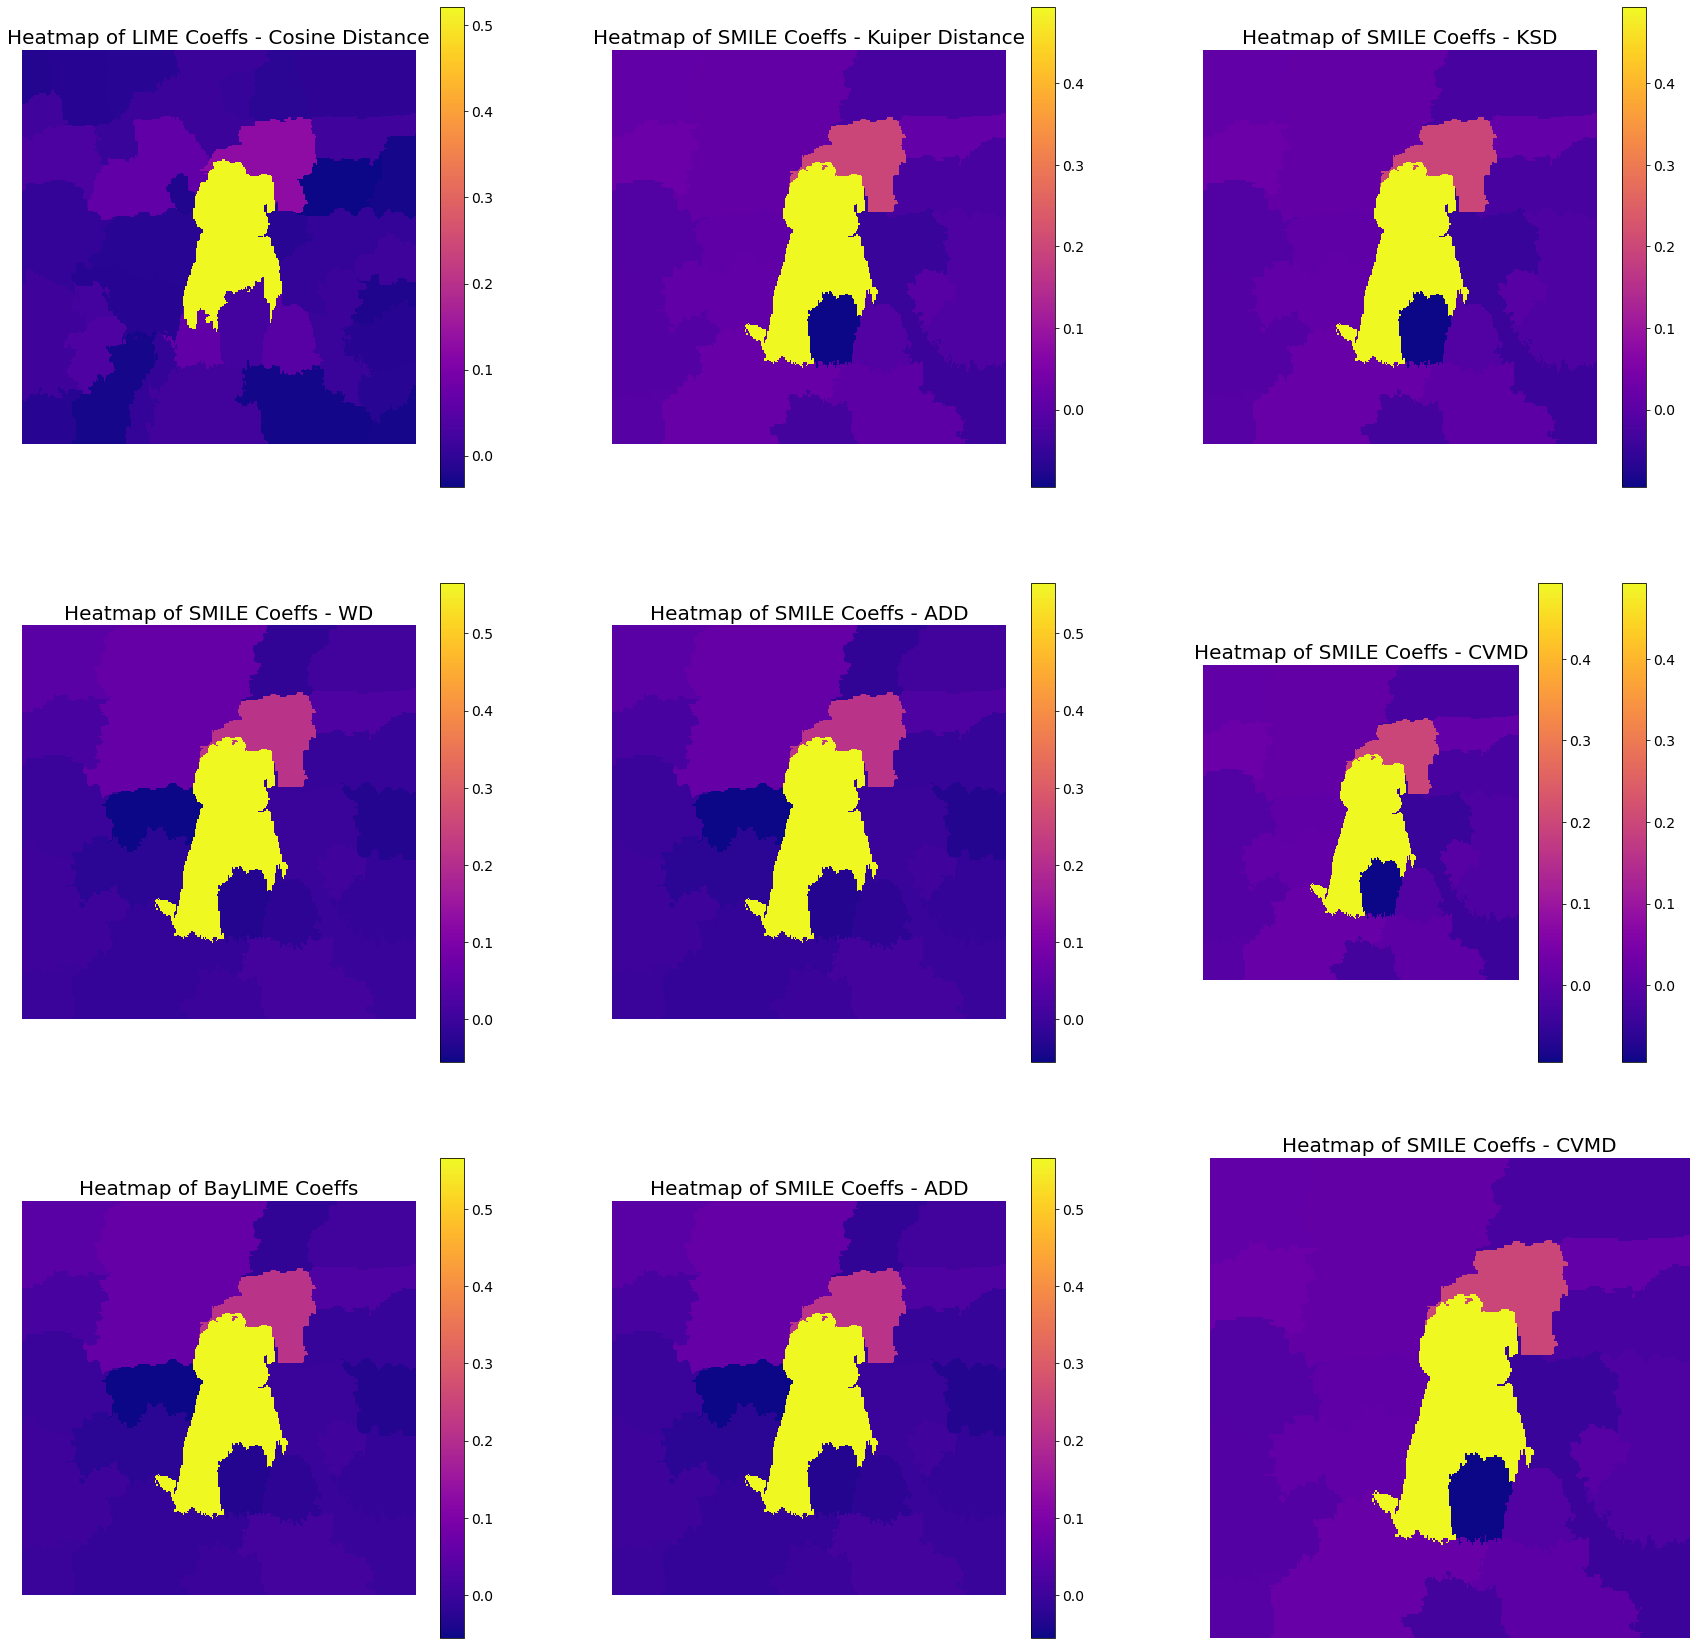

In [63]:
fig, axs = plt.subplots(3, 3, figsize=(30, 30)) 

fz = 20

im = axs[0,0].imshow(heat_mask_lime, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,0])
cbar.ax.tick_params(labelsize=14)  
axs[0,0].set_title('Heatmap of LIME Coeffs - Cosine Distance', fontsize= fz)
axs[0,0].axis('off')

im = axs[0,1].imshow(heat_mask_k, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,1])
cbar.ax.tick_params(labelsize=14)  
axs[0,1].set_title('Heatmap of SMILE Coeffs - Kuiper Distance', fontsize= fz)
axs[0,1].axis('off')

im = axs[0,2].imshow(heat_mask_ks, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[0,2])
cbar.ax.tick_params(labelsize=14)  
axs[0,2].set_title('Heatmap of SMILE Coeffs - KSD', fontsize= fz)
axs[0,2].axis('off')

im = axs[1,0].imshow(heat_mask_wd, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,0])
cbar.ax.tick_params(labelsize=14)  
axs[1,0].set_title('Heatmap of SMILE Coeffs - WD', fontsize= fz)
axs[1,0].axis('off')

im = axs[1,1].imshow(heat_mask_ad, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,1])
cbar.ax.tick_params(labelsize=14)  
axs[1,1].set_title('Heatmap of SMILE Coeffs - ADD', fontsize= fz)
axs[1,1].axis('off')

im = axs[1,2].imshow(heat_mask_cvm, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,2])
cbar.ax.tick_params(labelsize=14)  
axs[1,2].set_title('Heatmap of SMILE Coeffs - CVMD', fontsize= fz)
axs[1,2].axis('off')

im = axs[2,0].imshow(heat_mask_wd, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[2,0])
cbar.ax.tick_params(labelsize=14)  
axs[2,0].set_title('Heatmap of BayLIME Coeffs', fontsize= fz)
axs[2,0].axis('off')

im = axs[2,1].imshow(heat_mask_ad, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[2,1])
cbar.ax.tick_params(labelsize=14)  
axs[2,1].set_title('Heatmap of SMILE Coeffs - ADD', fontsize= fz)
axs[2,1].axis('off')

im = axs[2,2].imshow(heat_mask_cvm, cmap='plasma', interpolation='nearest')
cbar = fig.colorbar(im, ax=axs[1,2])
cbar.ax.tick_params(labelsize=14)  
axs[2,2].set_title('Heatmap of SMILE Coeffs - CVMD', fontsize= fz)
axs[2,2].axis('off')

In [64]:
plt.savefig('my_figure.png', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

<a id="comp_SHAP"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Comparing XWhy with SHAP</b></div>

Under construction....

In [65]:
# # Source: https://github.com/gradient-ai/interpretable-ml-keras/blob/main/Interpreting%20Computer%20Vision%20models.ipynb
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.preprocessing import image
# import shap
# import json 

# # load pretrained model
# model = ResNet50(weights='imagenet')
# def predict(x):
#     tmp = x.copy()
#     preprocess_input(tmp)
#     return model(tmp)

# # get imagenet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# with open(shap.datasets.cache(url)) as file:
#     class_names = [v[1] for v in json.load(file).values()]
    
# def load_img(path):
#     img = image.load_img(path, target_size=(224, 224))
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     return img

# img = load_img('/kaggle/input/baylimeimgex5/5.jpg')
    
# # define a masker that is used to mask out partitions of the input image.
# masker = shap.maskers.Image("inpaint_telea", img.shape[1:])

# # create an explainer with model and image masker
# explainer = shap.Explainer(predict, masker, output_names=class_names,algorithm='partition')

# # here we explain the same image and use 1000 evaluations of Resnet50 to get the shap values 
# shap_values = explainer(img, max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

In [66]:
# shap_values.shape

In [67]:
# shap.image_plot(shap_values)

<a id = "ref"></a>
<div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>References</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
* [[Interpretable Machine Learning with LIME for Image Classification]](https://nbviewer.org/url/arteagac.github.io/blog/lime_image.ipynb) by Cristian Arteaga used for Step-by-step implementation of LIME and then the rest of the code was added as the contribution of [X-Why](https://github.com/Dependable-Intelligent-Systems-Lab/xwhy).
* [[LIME Paper:]](https://arxiv.org/abs/1602.04938) Ribeiro, M. T., Singh, S., & Guestrin, C. (2016, August). " Why should i trust you?" Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1135-1144). [[LIME GitHub Repo]](https://github.com/marcotcr/lime).
* [[BayLIME Paper:]](https://proceedings.mlr.press/v161/zhao21a/zhao21a.pdf) Zhao, X., Huang, W., Huang, X., Robu, V., and Flynn, D. (2021, December). Baylime: Bayesian local interpretable model-agnostic explanations. In Uncertainty in artificial intelligence (pp. 887-896). PMLR. [[BayLIME GitHub Repo]](https://github.com/x-y-zhao/BayLime).
* [[SafeML Paper 1:]](https://arxiv.org/pdf/2005.13166.pdf) Aslansefat, K., Sorokos, I., Whiting, D., Tavakoli Kolagari, R., & Papadopoulos, Y. (2020). SafeML: safety monitoring of machine learning classifiers through statistical difference measures. In Model-Based Safety and Assessment: 7th International Symposium, IMBSA 2020, Lisbon, Portugal, September 14–16, 2020, Proceedings 7 (pp. 197-211). Springer International Publishing. [[SafeML GitHub Repo]](https://github.com/ISorokos/SafeML).
* [[SafeML Paper 2:]](https://bradscholars.brad.ac.uk/bitstream/handle/10454/18591/Abdullatif_ARA_2021.pdf?sequence=5) Aslansefat, K., Kabir, S., Abdullatif, A., Vasudevan, V., & Papadopoulos, Y. (2021). Toward improving confidence in autonomous vehicle software: A study on traffic sign recognition systems. Computer, 54(8), 66-76. [[SafeML GitHub Repo]](https://github.com/ISorokos/SafeML).   
* [🔥 EDA & ML on Game Play 🎮 (ongoing)](https://www.kaggle.com/code/nguyenthicamlai/eda-ml-on-game-play-ongoing) by [Nguyen Thi Cam Lai](https://www.kaggle.com/nguyenthicamlai) used for HTML-based headers

<center> <a href="#TOC" role="button" aria-pressed="true" >⬆️ Back to Table of Contents ⬆️</a>

<div style="border-radius:10px;border:#034914 solid;padding: 15px;background-color:aliceblue;font-size:90%;text-align:left">

<h4><b>Author :</b> Koorosh Aslansefat </h4>

<h4> <b>Some information:</b> </h4>

<b>👉Check my Kaggle Notebooks :</b> https://www.kaggle.com/kooaslansefat <br>
<b>👉Contact Me :</b> <a href="mailto:koo.ec2008@gmail.com">koo.ec2008@gmail.com</a><br>
<b>👉Find me LinkedIn :</b> www.linkedin.com/in/koorosh-aslansefat <br>
<b>👉Find me Github :</b> https://github.com/koo-ec <br>
    
    
<center> <strong> If you liked this Notebook, please do upvote. </strong>
    
<center> <strong> If you have any questions, feel free to contact me! </strong>
    
<center> <strong> ✨Best Wishes✨ </strong>

<center> <img src="https://gregcfuzion.files.wordpress.com/2022/01/kind-regards-2.png" style='width: 600px; height: 300px;'>